# Advanced geomechanics - WP2

Renato Poli (rep2656)

09/11/2023

# Exercise 1

Suport functions:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

def shear( sig_n, s1, s2 ) :
    """ 
    Creates a shear series for given values of principal stresses and sig_n
    """
    center = (s1 + s2)/2
    radius = (s1 - s2)/2
    dx = sig_n - center
    tau_sq = radius * radius - dx * dx
    tau_sq[ tau_sq < 0 ] = None
    return np.sqrt( tau_sq )

def mohr(s1, s2, s3, ax, title="") :
    """ 
    Plot Mohr diagram 
    """
    # Setup data
    npts = 1000
 
    [s1,s2,s3] = sorted([s1,s2,s3], reverse=True)
    step = (s1-s3)/npts
    sig_n = np.sort( np.append( np.arange(s3,s1,step), [s1, s2, s3]) )
    
    s12_tau = shear( sig_n, s1, s2 )
    s13_tau = shear( sig_n, s1, s3 )
    s23_tau = shear( sig_n, s2, s3 )

    # Do the plotting stuff
    ax.plot(sig_n, s12_tau, c='gray')
    ax.plot(sig_n, s23_tau, c='gray')
    ax.plot(sig_n, s13_tau, c='gray')

    ax.fill_between(sig_n, s12_tau, s13_tau, color='lightgray')
    ax.fill_between(sig_n, s23_tau, s13_tau, color='lightgray' )

    min, max = 900, 3500
    ax.set_xlim(min, max)
    ax.set_ylim(0, max-min)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel("Shear stress ($\\tau$)")
    ax.set_xlabel("Effective normal stress ($\sigma_n$)")

    return ax 

def mohr_to_axis(Sig, ax) :
    npts = 1000
 
    s1 = Sig[0,0]
    s2 = Sig[1,1]
    s3 = Sig[2,2]
    [s1,s2,s3] = sorted([s1,s2,s3], reverse=True)
    step = (s1-s3)/npts
    sig_n = np.sort( np.append( np.arange(s3,s1,step), [s1, s2, s3]) )
    
    s12_tau = shear( sig_n, s1, s2 )
    s13_tau = shear( sig_n, s1, s3 )
    s23_tau = shear( sig_n, s2, s3 )

    # Do the plotting stuff
    ax.plot(sig_n, s12_tau, c='gray')
    ax.plot(sig_n, s23_tau, c='gray')
    ax.plot(sig_n, s13_tau, c='gray')

    ax.fill_between(sig_n, s12_tau, s13_tau, color='lightgray')
    ax.fill_between(sig_n, s23_tau, s13_tau, color='lightgray' )


def print_matrix(A,title, ax=None) :
    txt = f"${title} = " +\
          r"\begin{bmatrix}" +\
          r' \\ '.join(r' & '.join('%0.0f' % (x+1e-6) for x in y) for y in A) +\
          r'\end{bmatrix}$'
    if not ax :
       fig,ax = plt.subplots()
    fig = ax.figure  
    fig.set_size_inches(3, 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    with mpl.rc_context({'text.usetex':1, 'text.latex.preamble': r'\usepackage{amsmath}'}):
      ax.text( 0.1, 0.5, txt, fontsize=8 )
      fig.tight_layout()
      plt.show()  

def SG_to_fault( Sg, Pp, dip, strike ) :
    # Fault coordinate system
    SS = np.sin(strike)
    CS = np.cos(strike)
    SD = np.sin(dip)
    CD =np.cos(dip)
    
    Nn = np.array([ -SS*SD, CS*SD, -CD ])
    Ns = np.array([ CS, SS, 0 ])
    Nd = np.array([ -SS*CD, CS*CD, SD ])

    SSg = Sg
    # Project Sg to the fault coordinate system
    T = SSg @ Nn
    sn = np.dot(T , Nn) - Pp
    tau = np.sqrt( np.dot(T , Nd)**2 + np.dot(T , Ns)**2 )

    return sn, tau

def process_fracture_set( Sg, Pp, DIP, STRIKE ) :
    SIGn, TAU = np.array([]), np.array([])
    for d,s in zip(DIP,STRIKE) : 
        sn, tau = SG_to_fault( Sg, Pp, d, s )
        SIGn = np.append( SIGn, sn)
        TAU  = np.append( TAU, tau )
    return SIGn, TAU

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

def SP_to_SG(Sp, alpha, beta, gamma) :
  # ROTATION MATRIX
  CA, SA = np.cos(alpha), np.sin(alpha)
  CB, SB = np.cos(beta),  np.sin(beta)
  CG, SG = np.cos(gamma), np.sin(gamma)
  RPG = np.array(
        [ [ CA*CB,                SA*CB            ,   -SB  ],
          [ CA*SB*SG - SA*CG,     SA*SB*SG + CA*CG , CB*SG  ],
          [ CA*SB*CG + SA*SG,     SA*SB*CG - CA*SG , CB*CG  ]]
  )

  # MATRIX MULTIPLICATION - STRESS IN GEOGRAPHIC COORDINATES
  Sg = RPG.T @ Sp @ RPG
  return Sg


1 - Input the principal stress tensor at Depth E in the principal directions coordinate system and calculate the tensor in the geographical coordinate system.

---

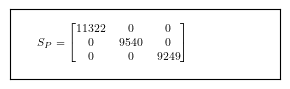

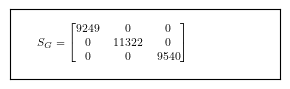

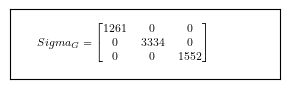

In [3]:
# POINT E TOTAL STRESS
Sp = np.array(
      [ [11322, 0     ,    0 ], 
        [ 0   , 9540  ,    0 ],
        [ 0   , 0     , 9249 ] ]
);
# Pore pressure
Pp = 7988

Sg = SP_to_SG ( Sp, np.pi/2, 0, np.pi/2 )

Sigma_g = Sg.copy()
Sigma_g[0,0] = Sigma_g[0,0] - Pp
Sigma_g[1,1] = Sigma_g[1,1] - Pp
Sigma_g[2,2] = Sigma_g[2,2] - Pp

## OUTPUT
print_matrix(Sp, "S_P")
print_matrix(Sg, "S_G")
print_matrix(Sigma_g, "Sigma_G")
# print(f"Sp = \n{Sp}")
# print(f"\nSg = \n{Sg}")
# print(f"\nSigma_g = \n{Sigma_g}")

2 - Generate 100 randomly distributed fracture orientations (strike and dip) and compute their effective normal stress and shear stress. Plot all in a $\sigma_n$ versus $\tau$ diagram together with the 3D Mohr circle(s). EXTRA 1 (not required): color symbols for each point $(\sigma_n,\tau)$ from blue to red (e.g., JET colormap) according to the value of $\tau / \sigma_n$. EXTRA 2 (not required): plot all fractures in a stereonet projection with symbols colored by the value of $\tau / \sigma_n$.

3 - Are there any fractures prone to shear slip (assume friction coefficient $\mu = 0.5 \pm 0.1$)? What fractures are likely to be hydraulically conductive based on the $\tau / \sigma_n$ criterion and which others are not?

---

*Answer*: Yes. They are the ones inside the shaded area of the plots.

***Note***: *I used 1000 fractures, as the results looked nicer to analyze*


''

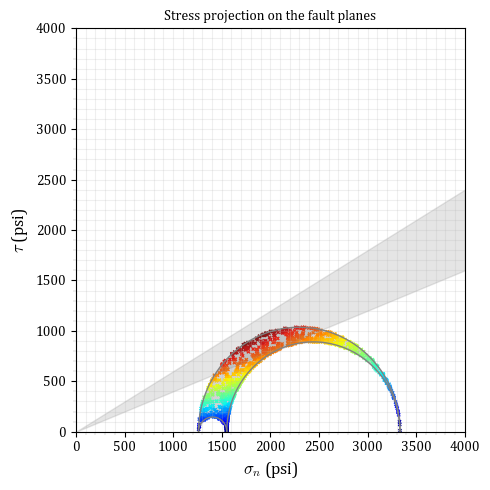

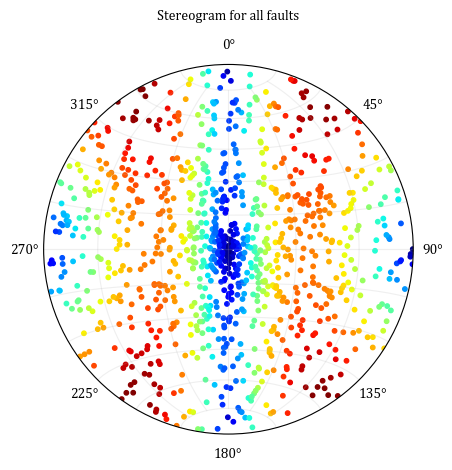

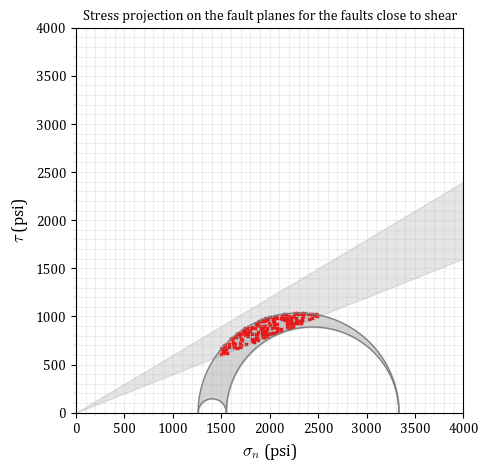

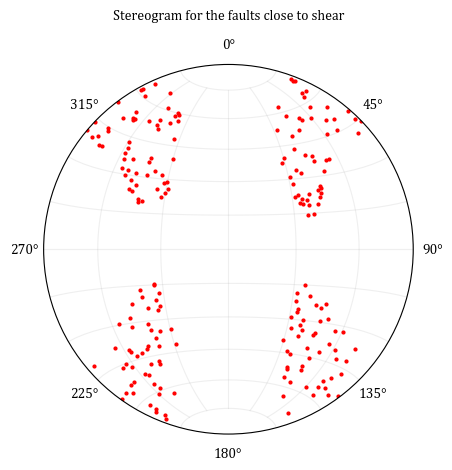

In [4]:
import numpy as np
import mplstereonet
import matplotlib.pyplot as plt

N=1000
DIP    = np.random.rand(N) * np.pi/2
STRIKE = np.random.rand(N) * np.pi * 2

# Processing
SIGn, TAU = process_fracture_set(Sg, Pp, DIP, STRIKE)

# Shear limits
shear_x = np.linspace(0,4000,10)
shear_y_p = shear_x * 0.6 
shear_y_n = shear_x * 0.4 

# Plot TAU x SIGn
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
mohr_to_axis( Sigma_g, ax )
ax.scatter(SIGn , TAU, s=5, marker = 'x', c=TAU/SIGn, cmap='jet')
ax.fill_between(shear_x, shear_y_n, shear_y_p, color='gray', alpha=0.2)
# Labels, limits
ax.set_xlabel("$\sigma_n$ (psi)")
ax.set_ylabel("$\\tau$ (psi)")
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)
ax.set_title("Stress projection on the fault planes")
fig.tight_layout()

# Plot full stereonet
fig, ax = mplstereonet.subplots()
x,y = STRIKE*180/np.pi, DIP*180/np.pi
lons, lats = mplstereonet.pole(x,y)
ax.scatter(lons, lats, c=TAU/SIGn, s=10, cmap='jet')
ax.set_title('Stereogram for all faults', y=1.10)

# Filter only the faults close to shear
stmap = ( TAU/SIGn > 0.4 )
x = SIGn[stmap]
y = TAU[stmap]

# Plot filtered TAU x SIGn
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
mohr_to_axis( Sigma_g, ax )
ax.scatter(x, y, s=5, marker = 'x', c='r')
ax.fill_between(shear_x, shear_y_n, shear_y_p, color='gray', alpha=0.2)
ax.set_xlabel("$\sigma_n$ (psi)")
ax.set_ylabel("$\\tau$ (psi)")
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)
ax.set_title("Stress projection on the fault planes for the faults close to shear")

# Plot filtered stereonet
x = (STRIKE*180/np.pi)[stmap]
y = (DIP*180/np.pi)[stmap]
fig, ax = mplstereonet.subplots()
ax.pole(x,y,markersize=2,color='r')
ax.set_title('Stereogram for the faults close to shear', y=1.10)

''

4 - Wellbore images actually show that there are two major fracture sets:

- Set 1: strike = 60 +/- 10 degrees, dip = 80 +/- 5 degrees
- Set 2: strike = 10 +/- 10 degresn, dip = 60 +/- 5 degrees

Plot results for 20 fractures for each set (errors represent one standard deviation of a normal distribution).
Which fracture set is more likely to slip in shear? Why?

---

*Answer*: Set 2 is more likely to slip in shear, because their stress state are more likely to touch the TAU/SIGn limit considered.

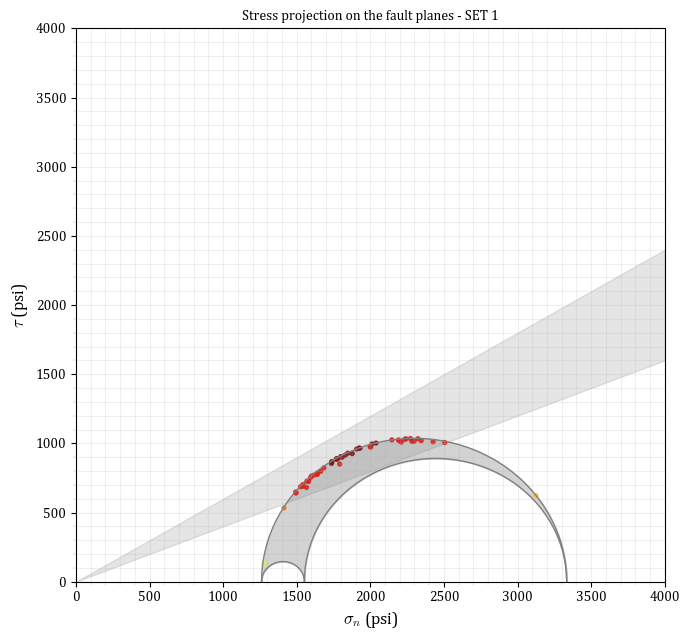

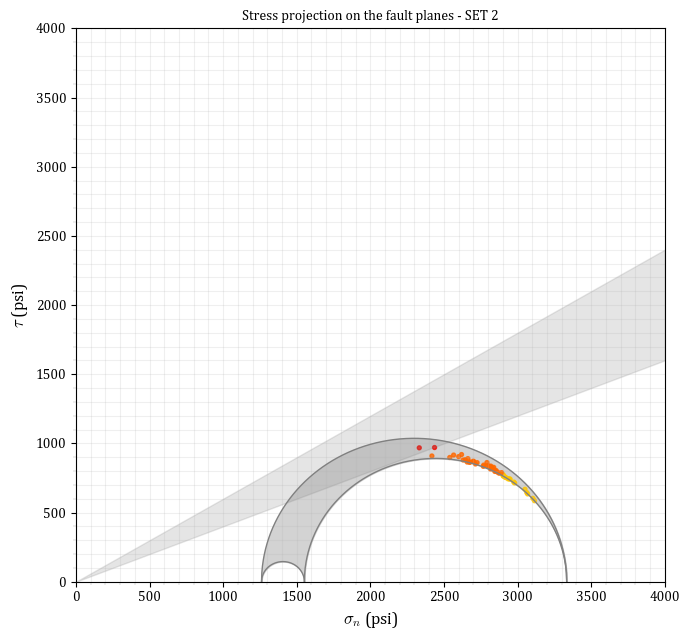

In [5]:
import numpy as np

N=50
s1_stk = np.random.normal(60,10,N) * np.pi / 180
s1_dip = np.random.normal(80,5,N)  * np.pi / 180

s2_stk = np.random.normal(10,10,N) * np.pi / 180
s2_dip = np.random.normal(60,5,N)  * np.pi / 180

s1_sn, s1_tau = process_fracture_set( Sg, Pp, s1_dip, s1_stk )
s2_sn, s2_tau = process_fracture_set( Sg, Pp, s2_dip, s2_stk )

import matplotlib as mpl
n_colors = 11
jetcm = mpl.colormaps['jet'].resampled(n_colors) # [0,1]
bins = np.linspace(-.5,0.6,n_colors)

s1_colors = [jetcm(i) for i in np.digitize(s1_tau / s1_sn, bins )]
s2_colors = [jetcm(i) for i in np.digitize(s2_tau / s2_sn, bins )]

# Plot TAU x SIGn
fig, ax = plt.subplots()
fig.set_size_inches(7,6.5)
mohr(1552,3334,1261, ax, "Point E")

ax.scatter(s1_sn , s1_tau, s=8, marker = 'o', c=s1_colors, alpha=.8)
ax.fill_between(shear_x, shear_y_n, shear_y_p, color='gray', alpha=0.2)
# Labels, limits
ax.set_xlabel("$\sigma_n$ (psi)")
ax.set_ylabel("$\\tau$ (psi)")
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)
ax.set_title("Stress projection on the fault planes - SET 1")
fig.tight_layout()

# Plot TAU x SIGn
fig, ax = plt.subplots()
fig.set_size_inches(7,6.5)

mohr(1552,3334,1261, ax, "Point E")
ax.scatter(s2_sn , s2_tau, s=8, marker = 'o', c=s2_colors, alpha=.8)
ax.fill_between(shear_x, shear_y_n, shear_y_p, color='gray', alpha=0.2)
# Labels, limits
ax.set_xlabel("$\sigma_n$ (psi)")
ax.set_ylabel("$\\tau$ (psi)")
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)
ax.set_title("Stress projection on the fault planes - SET 2")
fig.tight_layout()


# Exercise 2

Prepare the database.

---

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv("fault_data.txt", sep='\t')

dSv_dz = 1 # psi/ft
dPp_dz = 0.44 # psi/ft

df.origin = df.origin.apply(eval).apply(np.array)
df.end = df.end.apply(eval).apply(np.array)

df['dist'] = df.end - df.origin
df['strike'] = df.apply( lambda x: np.arctan2(x.dist[0], x.dist[1]) , axis=1)
df['dip'] = df.dip * np.pi / 180
mask = df.dip_dir.str.contains('N')
df.loc[mask,"strike"] = df[mask].strike + np.pi

df['strike_deg'] = df.strike * 180 / np.pi
df['dip_deg'] = df.dip * 180 / np.pi

df['Sv'] = dSv_dz * df.depth
df['Pp'] = dPp_dz * df.depth
df['Shmin'] = 0.76 * df.Sv
df['Shmax'] = 0.79 * df.Sv
df['Sg'] = df.apply( lambda x : np.array( [ [ x.Shmin, 0, 0 ], [ 0, x.Shmax, 0 ], [ 0, 0, x.Sv ]] ), axis=1 )
df['Sigg'] = df.apply( lambda x : np.array( [ [ (x.Shmin-x.Pp), 0, 0 ], [ 0, (x.Shmax-x.Pp), 0 ], [ 0, 0, (x.Sv-x.Pp) ]] ), axis=1 )
df['Sigg_div_Sigv'] = df.apply( lambda x : np.array( [ [ (x.Shmin-x.Pp)/(x.Sv-x.Pp), 0, 0 ], [ 0, (x.Shmax-x.Pp)/(x.Sv-x.Pp), 0 ], [ 0, 0, 1 ]] ), axis=1 )
df['Sigv'] = df.Sv - df.Pp

def process_fracture_set_2( SG, PP, DIP, STRIKE ) :
    SIGn, TAU = np.array([]), np.array([])
    for Sg, Pp, d,s in zip(SG, PP, DIP,STRIKE) : 
        sn, tau = SG_to_fault( Sg, Pp, d, s )
        SIGn = np.append( SIGn, sn)
        TAU  = np.append( TAU, tau )
    return SIGn, TAU

SIGn, TAU = process_fracture_set_2( df.Sg, df.Pp, df.dip, df.strike )

df['SIGn'] = SIGn
df['TAU'] = TAU

df['SIGn_div_Sv'] = df.SIGn / df.Sigv
df['TAU_div_Sv'] = df.TAU / df.Sigv

# Dump some columns of the database 
df[["id","dip_deg","strike_deg","dip_dir","Sv", "Shmin", "Shmax", "Pp"]]

,id,dip_deg,strike_deg,dip_dir,Sv,Shmin,Shmax,Pp
0,F1a,53.0,102.396596,SW,7250,5510.0,5727.5,3190.0
1,F1b,53.0,84.619659,S,7150,5434.0,5648.5,3146.0
2,F1c,53.0,76.685609,SE,7050,5358.0,5569.5,3102.0
3,F1d,53.0,52.908764,SE,7300,5548.0,5767.0,3212.0
4,F2,52.0,60.958149,SE,7500,5700.0,5925.0,3300.0
5,F3,55.0,50.748072,SE,7800,5928.0,6162.0,3432.0
6,F4a,56.0,74.536837,SE,7400,5624.0,5846.0,3256.0
7,F4b,56.0,91.718757,S,7400,5624.0,5846.0,3256.0
8,F4c,56.0,121.572028,SW,7500,5700.0,5925.0,3300.0
9,F4d,56.0,95.453238,S,7700,5852.0,6083.0,3388.0


1 - Calculate the stress tensor for each fault. The direction of $S_{hmin}$ is N-S.


In [7]:
df.apply( lambda x: print(f"\n{x.id}=\n{x.Sg}") , axis=1)
''


F1a=
[[5510.     0.     0. ]
 [   0.  5727.5    0. ]
 [   0.     0.  7250. ]]

F1b=
[[5434.     0.     0. ]
 [   0.  5648.5    0. ]
 [   0.     0.  7150. ]]

F1c=
[[5358.     0.     0. ]
 [   0.  5569.5    0. ]
 [   0.     0.  7050. ]]

F1d=
[[5548.    0.    0.]
 [   0. 5767.    0.]
 [   0.    0. 7300.]]

F2=
[[5700.    0.    0.]
 [   0. 5925.    0.]
 [   0.    0. 7500.]]

F3=
[[5928.    0.    0.]
 [   0. 6162.    0.]
 [   0.    0. 7800.]]

F4a=
[[5624.    0.    0.]
 [   0. 5846.    0.]
 [   0.    0. 7400.]]

F4b=
[[5624.    0.    0.]
 [   0. 5846.    0.]
 [   0.    0. 7400.]]

F4c=
[[5700.    0.    0.]
 [   0. 5925.    0.]
 [   0.    0. 7500.]]

F4d=
[[5852.    0.    0.]
 [   0. 6083.    0.]
 [   0.    0. 7700.]]

F4e=
[[6308.    0.    0.]
 [   0. 6557.    0.]
 [   0.    0. 8300.]]

F4f=
[[6346.     0.     0. ]
 [   0.  6596.5    0. ]
 [   0.     0.  8350. ]]

F5a=
[[6080.    0.    0.]
 [   0. 6320.    0.]
 [   0.    0. 8000.]]

F5b=
[[6232.    0.    0.]
 [   0. 6478.    0.]
 [   0. 

''

2 - Calculate the effective normal stress $\sigma_n$ and shear stress $\tau$ on each fault and plot the results together in a normalized 3D Mohr circle with x-axis ( $\sigma_n / \sigma_v$) and y-axis ( $\tau / \sigma_v$). Assume hydrostatic pore pressure d$P_p/$   d$z = 0.44$ psi/ft.

3 - Are there any faults prone to reactivation (assume friction coefficient $\mu = 0.6$)? If yes, what faults are those?

---

*Answer:* No. There are no faults prone to reactivation.

---

4 - Assuming that fluid injection would shift Mohr circles to lower $\sigma_n$ values without change of $\tau$ values (circle moves to the left without change of diameter - conservative assumption), what is the maximum allowable pressure increase without causing fault reactivation?

---

*Answer:* I could find a pressure shift of around $1263$ psi before any shear would occur. I used $0.5 < \mu < 0.6$ as the range of analysis

The maximum preessure shift allowed  is: 1263.4 psi.


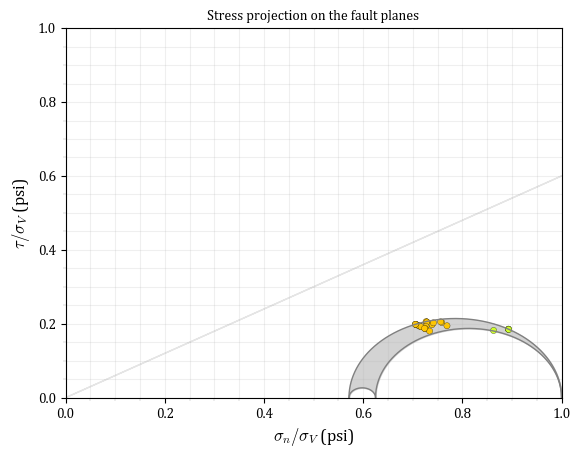

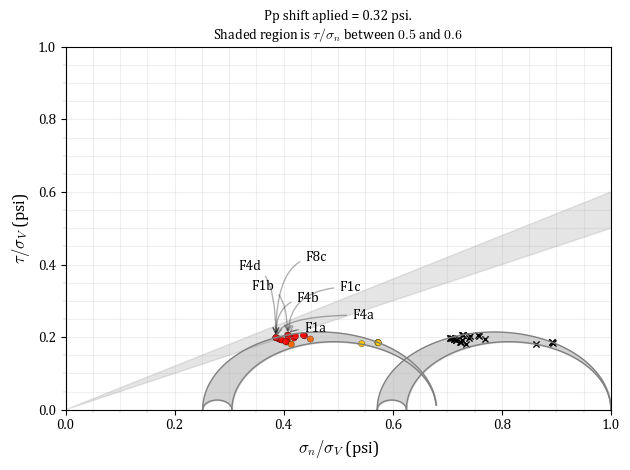

In [8]:
import matplotlib as mpl

SIGn, TAU = process_fracture_set_2( df.Sg, df.Pp, df.dip, df.strike )

# Set values on the dataframe
df['SIGn'] = SIGn
df['TAU'] = TAU
df['SIGn_div_Sv'] = df.SIGn / df.Sigv
df['TAU_div_Sv'] = df.TAU / df.Sigv

df['TAU_div_SIGn'] = df.TAU_div_Sv / df.SIGn_div_Sv

# Plot TAU x SIGn
fig, ax = plt.subplots()

n_colors = 11
jetcm = mpl.colormaps['jet'].resampled(n_colors) # [0,1]
bins = np.linspace(-.5,0.7,n_colors)
c = [jetcm(i) for i in np.digitize(df.TAU_div_Sv / df.SIGn_div_Sv, bins )]

for k, x in df.iterrows() :
    mohr_to_axis( x.Sigg_div_Sigv, ax )
    break

# Shear limits
shear_x = np.linspace(0,6000,10)
shear_y_p = shear_x * 0.6 
shear_y_n = shear_x * 0.6
ax.fill_between(shear_x, shear_y_n, shear_y_p, color='gray', alpha=0.2)
# Labels, limits
ax.set_xlabel("$\sigma_n / \sigma_V$ (psi)")
ax.set_ylabel("$\\tau / \sigma_V$ (psi)")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title("Stress projection on the fault planes")
ax.scatter(df.SIGn_div_Sv , df.TAU_div_Sv, s=20, marker = 'o', c=c, edgecolors='k', linewidth=.2)


#
# Maximum injection pressure
#

# Plot TAU x SIGn
fig, ax = plt.subplots()

for k, x in df.iterrows() :
    mohr_to_axis( x.Sigg_div_Sigv, ax )
    break

ax.scatter(df.SIGn_div_Sv , df.TAU_div_Sv, s=20, marker = 'x', c='k')
Pp_shift = 0.32
df["max_Pp"] = df.Sigv * Pp_shift
print(f"The maximum preessure shift allowed  is: {df.max_Pp.min():.1f} psi.")
c = [jetcm(i) for i in np.digitize(df.TAU_div_Sv / (df.SIGn_div_Sv-Pp_shift), bins )]

for k, x in df.iterrows() :
    S_shift = x.Sigg_div_Sigv.copy()
    S_shift[0,0] = S_shift[0,0] - Pp_shift
    S_shift[1,1] = S_shift[1,1] - Pp_shift
    S_shift[2,2] = S_shift[2,2] - Pp_shift
    mohr_to_axis( S_shift, ax )
    break

ax.scatter(df.SIGn_div_Sv - Pp_shift, df.TAU_div_Sv, s=20, marker = 'o', c=c, edgecolors='k', linewidth=.2)
# Shear limits
shear_x = np.linspace(0,6000,10)
shear_y_p = shear_x * 0.5 
shear_y_n = shear_x * 0.6
ax.fill_between(shear_x, shear_y_n, shear_y_p, color='gray', alpha=0.2)
# Labels, limits
ax.set_xlabel("$\sigma_n / \sigma_V$ (psi)")
ax.set_ylabel("$\\tau / \sigma_V$ (psi)")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title(f"Pp shift aplied = {Pp_shift} psi.\nShaded region is $\\tau/\sigma_n$ between $0.5$ and $0.6$")

df["Tau_div_Sign_Shifted"] = df.TAU_div_Sv / (df.SIGn_div_Sv - Pp_shift)

for t,x,y in zip(df.id, df.SIGn_div_Sv - Pp_shift, df.TAU_div_Sv) :
    dx = np.random.rand()*.4 - .2
    dy = np.random.rand()*.3
    if y/x < 0.4 :
        dy = -np.abs(dy)
    else:
        dy = np.abs(dy)
    if y/x > 0.5 : 
        ax.annotate(t, (x,y), xytext=(x+dx, y+dy),
        arrowprops = dict(  arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90", alpha=0.3))


fig.tight_layout()
# df.to_excel("test.xlsx")

5 - Plot the faults as straight lines in a 2D top view map and identify faults closer to reactivation. Suggestion: color segments according to the value of $\tau / \sigma_n$ where red is high likelihood for reactivation and blue is low likelihood for reactivation.

---

''

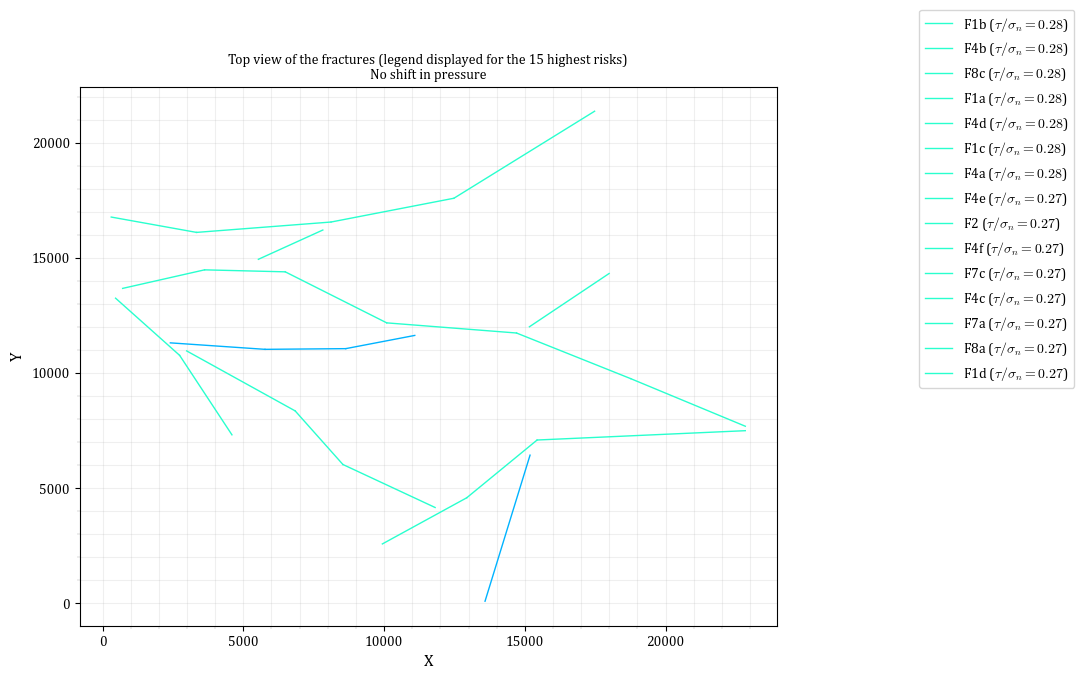

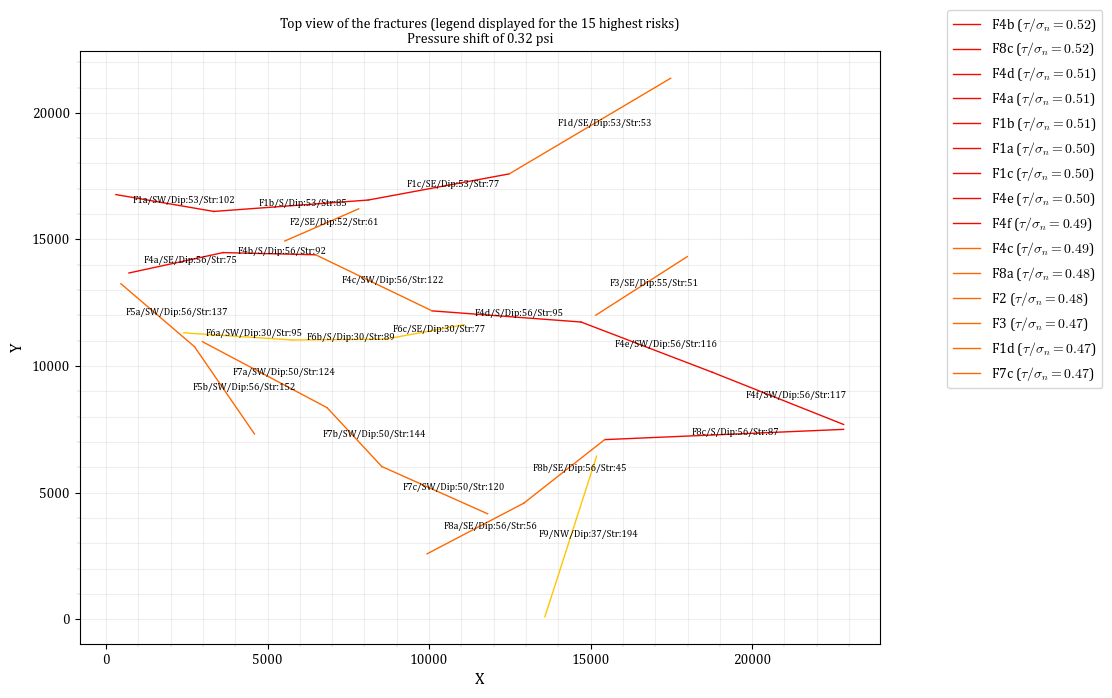

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
n_colors = 11
jetcm = mpl.colormaps['jet'].resampled(n_colors) # [0,1]

df['color_bin'] = pd.cut( df.TAU_div_SIGn, bins=np.linspace(0,0.6,n_colors), labels=False )
df['color'] = df.apply( lambda x : jetcm( x.color_bin ), axis=1)

df_sorted = df.sort_values("TAU_div_SIGn",ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(9,7)
count=0
for k, x in df_sorted.iterrows() :
    lab = x.id + f" ($\\tau/\sigma_n={x.TAU_div_SIGn:.2f}$)"
    count = count + 1
    if count > 15 : lab = ""
    ax.plot( [ x.origin[0], x.end[0] ], [ x.origin[1], x.end[1] ], c=x.color , label=lab)

ax.set_xlabel( 'X' )
ax.set_ylabel( 'Y' )
ax.set_title("Top view of the fractures (legend displayed for the 15 highest risks)\nNo shift in pressure")
fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


#
# Now shifting the pressure
#
bins = np.linspace(-.5,0.6,n_colors)
df['color_bin'] = pd.cut( df.Tau_div_Sign_Shifted, bins=bins, labels=False )
df['color'] = df.apply( lambda x : jetcm( x.color_bin ), axis=1)

df_sorted = df.sort_values("Tau_div_Sign_Shifted",ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(9,7)

count=0
for k, x in df_sorted.iterrows() :
    lab = x.id + f" ($\\tau/\sigma_n={x.Tau_div_Sign_Shifted:.2f}$)"
    count = count + 1
    if count > 15 : lab = ""
    ax.plot( [ x.origin[0], x.end[0] ], [ x.origin[1], x.end[1] ], c=x.color , label=lab)
    
    xx = x.origin[0]/2 + x.end[0]/2 - 1000
    yy = x.origin[1]/2 + x.end[1]/2
    ax.text(xx,yy,x.id + f"/{x.dip_dir}/Dip:{x.dip*180/np.pi:.0f}/Str:{x.strike*180/np.pi:.0f}",fontsize=7)

ax.set_xlabel( 'X' )
ax.set_ylabel( 'Y' )
ax.set_title(f"Top view of the fractures (legend displayed for the 15 highest risks)\nPressure shift of {Pp_shift} psi")
fig.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout()

""